In [1]:
from skimage.feature import SIFT
from PIL import Image
import numpy as np
import os
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC , SVC
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable
import splitfolders
from sklearn.metrics import f1_score , classification_report ,confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score , precision_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

# fonctions 

In [8]:
def evaluation(model ,X_train , X_test ,y_train, y_test ):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    rapport = classification_report(y_test,ypred)
    print('Rapport de Classification : \n',rapport)
    print("Accuracy: ", accuracy_score(y_test, ypred))
    print("Recall : ", recall_score(y_test, ypred, average='macro'))
    print("Precision: ", precision_score(y_test, ypred, average='macro'))
    print("F1 score: ", f1_score(y_test, ypred, average='macro'))
    
    cm = confusion_matrix(y_test,ypred)

    sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'notumor', 'pituitary'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Réelle',fontsize=13)
    plt.title('Matrice de confusion',fontsize=17)
    plt.show()
    return model

def save_model(name , modele):
    joblib.dump(modele, f'{name}.pkl')

def spite_data_train_test_validation(input_folder ,outpur_folder ):
    splitfolders.ratio(input_folder, output=outpur_folder,
            seed=42, ratio=(.8, .2, .0), group_prefix=None)

def imglistFolder(path):    
    return [os.path.join(path, f) for f in os.listdir(path)]

def imgList(imagesListFolder):
        class_id = 0
        image_paths = []
        image_classes = []
        for training_name in imagesListFolder: 
            class_path = imglistFolder(training_name)
            image_paths += class_path
            image_classes += [class_id]*len(class_path) 
            class_id +=1
            
        return image_paths  , image_classes

#les descrepteur    
def descreptors(image_paths):
        des_list = []
        descriptor_extractor = SIFT()
        for image_path in image_paths:
            img = np.array(Image.open(image_path).convert('L').resize((128 ,128)) )
            descriptor_extractor.detect_and_extract(img) 
            kpts = descriptor_extractor.keypoints 
            des = descriptor_extractor.descriptors 
            des_list.append((image_path , des)) 
        
        descriptors = des_list[0][1] 
        for image_path , des in des_list[1 : ]:
            descriptors = np.vstack((descriptors , des))
            
        
        return descriptors.astype(float) , des_list

def calculerHistogramme(codebook , image_paths ,des_list  , k ):
    im_features = np.zeros((len(image_paths), k), "float32")
    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1], codebook)
        for w in words:
            im_features[i][w] += 1
                
    nbr_occurences = np.sum( (im_features > 0 ) * 1, axis = 0)
    #idf = np.array(np.log((1.0*len(self.image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')
    #Normaliser les features en supprimant la moyenne et en mettant à l'échelle la variance unitaire
        
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)
        
    return im_features  , stdSlr 

In [3]:
def get_data(path_train , path_test , k = 200):
    # train 
    imagesListFolder = imglistFolder(path_train)
    #classes_names = os.listdir(path_train)
    image_paths_train ,Y_train = imgList(imagesListFolder)
    descreptors_train, des_train = descreptors(image_paths_train)
    codebook , variance = kmeans(descreptors_train, k, 1)
    X_train , stdSlr = calculerHistogramme(codebook , image_paths_train , des_train , k)
    #
    
    imagesListFolderTest = imglistFolder(path_test) 
    image_test_paths , Y_test = imgList(imagesListFolderTest)
    descreptors_test  , des_test= descreptors(image_test_paths)
    X_test , stdSlr_test = calculerHistogramme(codebook , image_test_paths , des_test , k )
        
    return X_train , Y_train , X_test , Y_test

In [ ]:
X_train , Y_train , X_test , Y_test = get_data("dataset2/train" , "dataset2/test")

In [4]:
#joblib.dump((X_train , Y_train , X_test , Y_test ), "train_data.pkl", compress=3)
X_train , Y_train , X_test , Y_test = joblib.load('train_data.pkl')

# SVM

Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       300
           1       0.77      0.69      0.73       306
           2       0.97      0.97      0.97       405
           3       0.81      0.88      0.85       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311

Accuracy:  0.8497330282227308
Recall :  0.8401942628903414
Precision:  0.8385916789260326
F1 score:  0.8384682870817847


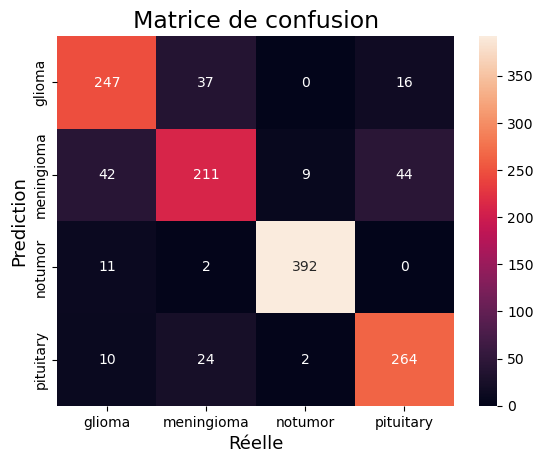

In [6]:
model = SVC()
model = evaluation(model ,X_train , X_test ,Y_train, Y_test )

# Random Forest

Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.79      0.65      0.72       300
           1       0.71      0.70      0.70       306
           2       0.98      1.00      0.99       405
           3       0.74      0.86      0.79       300

    accuracy                           0.82      1311
   macro avg       0.80      0.80      0.80      1311
weighted avg       0.82      0.82      0.81      1311

Accuracy:  0.816933638443936
Recall :  0.8015196078431372
Precision:  0.8036889702420512
F1 score:  0.799854071833273


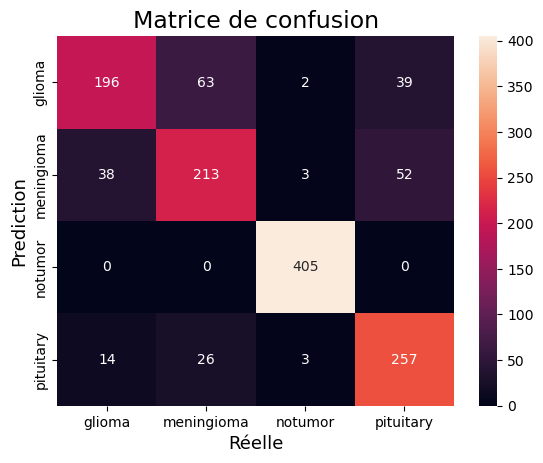

In [8]:
rf_model = RandomForestClassifier()
rf_model = evaluation(rf_model ,X_train , X_test ,Y_train, Y_test )

# Decision Tree

Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.62      0.51      0.56       300
           1       0.57      0.63      0.60       306
           2       0.91      0.87      0.89       405
           3       0.60      0.66      0.63       300

    accuracy                           0.69      1311
   macro avg       0.67      0.67      0.67      1311
weighted avg       0.69      0.69      0.69      1311

Accuracy:  0.6857360793287567
Recall :  0.6695152505446623
Precision:  0.6725968405581595
F1 score:  0.6689370829153282


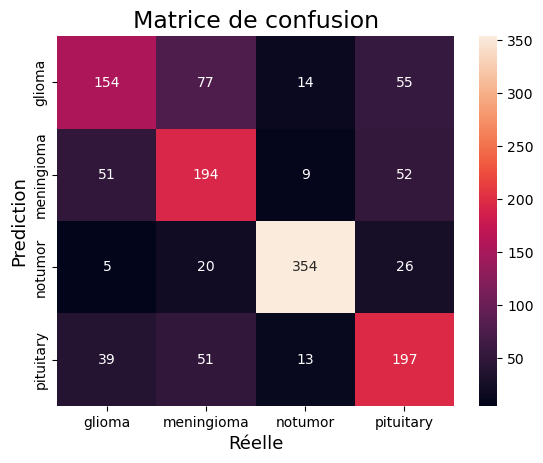

In [12]:
DT_model = DecisionTreeClassifier() 
DT_model = evaluation(DT_model ,X_train ,X_test ,Y_train ,Y_test)

# classificateur bayésien

Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.58      0.71      0.64       300
           1       0.41      0.31      0.35       306
           2       0.86      0.77      0.81       405
           3       0.62      0.71      0.66       300

    accuracy                           0.64      1311
   macro avg       0.62      0.63      0.62      1311
weighted avg       0.64      0.64      0.63      1311

Accuracy:  0.6369183829138062
Recall :  0.6268736383442266
Precision:  0.6168786534073549
F1 score:  0.6168061807044877


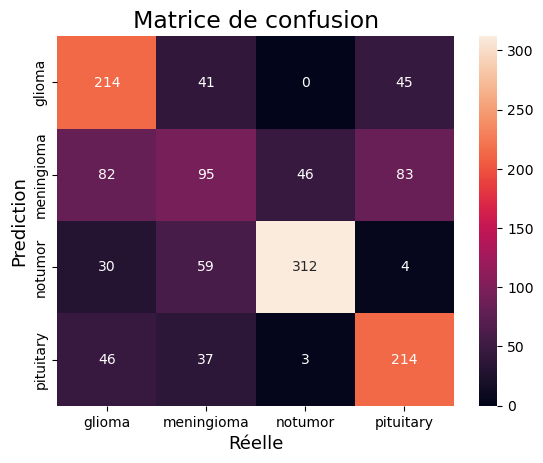

In [14]:
naive_bayes = GaussianNB()
naive_bayes = evaluation(naive_bayes ,X_train ,X_test ,Y_train ,Y_test)

# Logistic Regression

Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       300
           1       0.65      0.55      0.59       306
           2       0.89      0.88      0.88       405
           3       0.75      0.82      0.78       300

    accuracy                           0.77      1311
   macro avg       0.75      0.76      0.76      1311
weighted avg       0.77      0.77      0.77      1311

Accuracy:  0.7681159420289855
Recall :  0.7595079883805373
Precision:  0.7549749940462015
F1 score:  0.7555964467635158


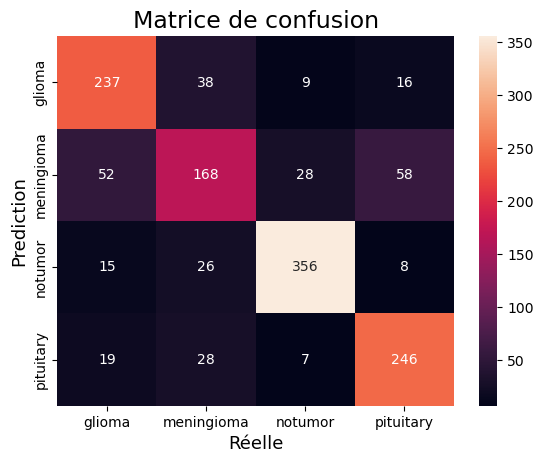

In [16]:
LR_model = LogisticRegression()
LR_model = evaluation(LR_model ,X_train ,X_test ,Y_train ,Y_test)

# Grid Search

In [15]:
def get_model(name_model , parameter= {}):
    
    if name_model =="LogisticRegression":
        return [ LogisticRegression(),LogisticRegression(**parameter)]
    elif name_model =="SVC":
        return [SVC() , SVC(**parameter)]
    elif name_model== "DecisionTreeClassifier":
        return [ DecisionTreeClassifier() , DecisionTreeClassifier(**parameter)]
    elif name_model == "RandomForestClassifier":
        
        return [RandomForestClassifier() , RandomForestClassifier(**parameter)]
    elif name_model =="GaussianNB":
        return [GaussianNB(), GaussianNB(**parameter)],
    
    
def grid_serche_model(model_name ,param_grid , X_train , X_test , Y_train , Y_test):
    grid_search = GridSearchCV(estimator=get_model(model_name)[0], param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    best_params = grid_search.best_params_
    print("--------------------------------")
    print("best_params : " , best_params )
    print("--------------------------------")
    best_model = grid_search.best_estimator_
    best_model =get_model(model_name ,best_params )[0]
    best_model = evaluation(best_model ,X_train ,X_test ,Y_train ,Y_test)    
    return best_model


# Grid Search SVM

--------------------------------
best_params :  {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
--------------------------------
Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       300
           1       0.77      0.69      0.73       306
           2       0.97      0.97      0.97       405
           3       0.81      0.88      0.85       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311

Accuracy:  0.8497330282227308
Recall :  0.8401942628903414
Precision:  0.8385916789260326
F1 score:  0.8384682870817847


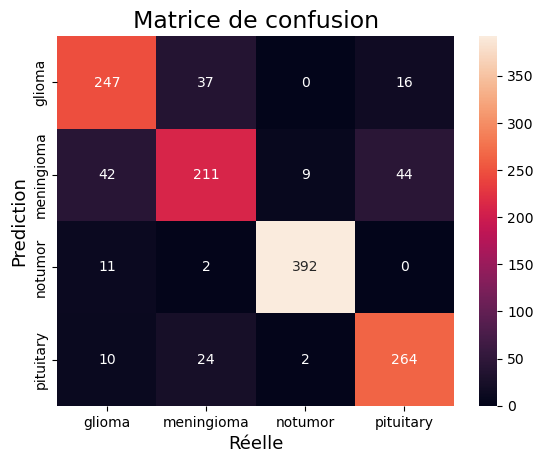

In [24]:
param_grid = {
        'C': [1, 10, 100],
         'gamma': [0.001, 0.01, 0.1, 'scale', 'auto'],
         'kernel': ['rbf'],
         'class_weight': ['balanced'],
}
SVC_model_grid = grid_serche_model("SVC" , param_grid ,  X_train , X_test , Y_train , Y_test)

# Grid Search Random Forest

--------------------------------
best_params :  {'max_depth': 20, 'n_estimators': 100}
--------------------------------
Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.81      0.68      0.74       300
           1       0.74      0.71      0.72       306
           2       0.97      1.00      0.99       405
           3       0.74      0.87      0.80       300

    accuracy                           0.83      1311
   macro avg       0.82      0.81      0.81      1311
weighted avg       0.83      0.83      0.83      1311

Accuracy:  0.8276125095347063
Recall :  0.8131372549019609
Precision:  0.8162169583395227
F1 score:  0.8116472027652089


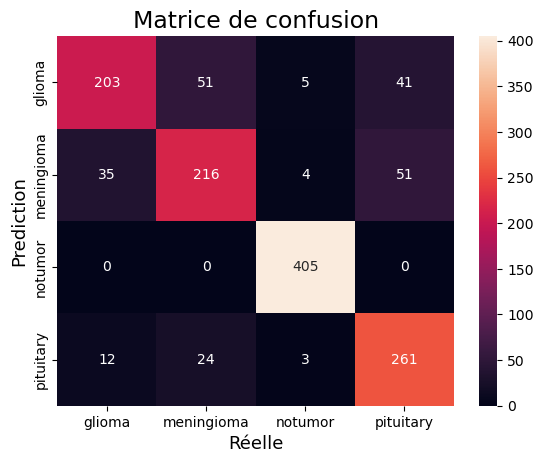

In [9]:
param_grid = {
        'n_estimators': [10, 50, 100 ],
        'max_depth': [None, 10, 20],
    }

best_RF_model = grid_serche_model("RandomForestClassifier" , param_grid ,  X_train , X_test , Y_train , Y_test )

# Grid Search Decision Tree

--------------------------------
best_params :  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
--------------------------------
Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.61      0.52      0.56       300
           1       0.55      0.62      0.59       306
           2       0.90      0.87      0.88       405
           3       0.57      0.61      0.59       300

    accuracy                           0.67      1311
   macro avg       0.66      0.66      0.66      1311
weighted avg       0.68      0.67      0.67      1311

Accuracy:  0.6720061022120518
Recall :  0.6552124183006536
Precision:  0.6590061250833184
F1 score:  0.6553767840901115


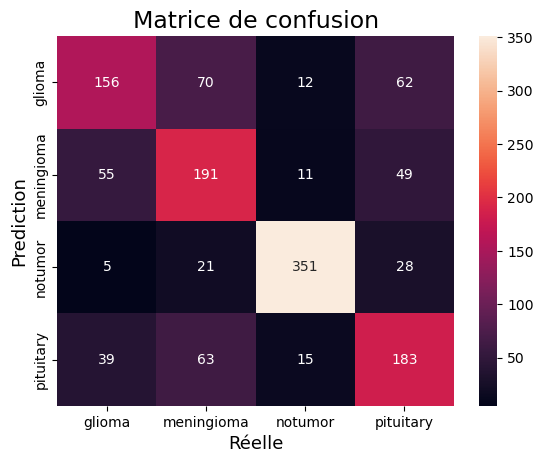

In [10]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


best_DT_model = grid_serche_model("DecisionTreeClassifier" , param_grid ,  X_train , X_test , Y_train , Y_test)

# Grid Search Logistic Regression

--------------------------------
best_params :  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
--------------------------------
Rapport de Classification : 
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       300
           1       0.65      0.55      0.59       306
           2       0.89      0.88      0.88       405
           3       0.75      0.82      0.78       300

    accuracy                           0.77      1311
   macro avg       0.75      0.76      0.76      1311
weighted avg       0.77      0.77      0.77      1311

Accuracy:  0.7681159420289855
Recall :  0.7595079883805373
Precision:  0.7549749940462015
F1 score:  0.7555964467635158


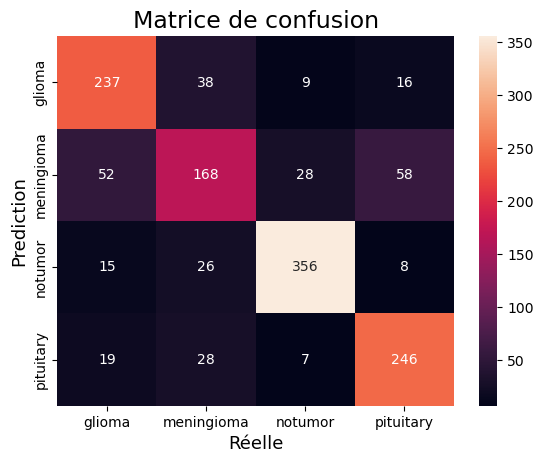

In [12]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

best_LR_model = grid_serche_model("LogisticRegression" , param_grid ,  X_train , X_test , Y_train , Y_test)